# Post Transforms with spleen segmentation task

MONAI provides post-processing transforms for handling the model outputs. Currently, the transforms include:
* `Activations`: Adding activation layer (Sigmoid, Softmax, etc.).
* `AsDiscrete`: Converting to discrete values (Argmax, One-Hot, Threshold value, etc).
* `SplitChannel`: Splitting multi-channel data into multiple single channels.
* `KeepLargestConnectedComponent`: Extracting contour of segmentation result, which can be used to map to original image and evaluate the model.
* `LabelToContour`: Removing segmentation noise based on Connected Component Analysis.

MONAI supports multiple transform chains to apply different pre-transforms or post-transforms on the same data and concatenate the results, it provides `CopyItems` transform to make copies of specified items in the data dictionary and `ConcatItems` transform to combine specified items on the expected dimension, and also provides `DeleteItems` transform to delete unnecessary items to save memory.

A typical usage is to scale and concatenate 3 different intensity ranges of an input image:
<p>
<img src="./images/multi_transform_chains.png" width="70%" alt='multi_transform_chains'>
</p>

This tutorial shows several of above post transforms based on the model output of spleen segmentation.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/MONAI/blob/master/examples/notebooks/post_transforms.ipynb)

## Setup environment

In [1]:
%pip install -qU "monai[gdown, nibabel, skimage]"

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -qU matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## Setup imports

In [3]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob
import os
import shutil
import tempfile

import IPython
import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import compute_meandice
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    Compose,
    CropForegroundd,
    KeepLargestConnectedComponent,
    LabelToContour,
    LoadNiftid,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.2.0
Python version: 3.7.5 (default, Nov  7 2019, 10:50:52)  [GCC 8.3.0]
Numpy version: 1.19.1
Pytorch version: 1.6.0

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.1.1
scikit-image version: 0.17.2
Pillow version: 7.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/bengorman/notebooks/


## Download dataset

Downloads and extracts the dataset.
The dataset comes from http://medicaldecathlon.com/.

In [5]:
resource = "https://drive.google.com/uc?id=1jzeNU1EKnK81PyTsrx0ujfNl-t0Jo8uE"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")

download_and_extract(resource, compressed_file, root_dir, md5)

file /home/bengorman/notebooks/Task09_Spleen.tar exists, skip downloading.
extracted file /home/bengorman/notebooks/Task09_Spleen exists, skip extracting.


## Set MSD Spleen dataset path

In [6]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Set deterministic training for reproducibility

In [7]:
set_determinism(seed=0)

## Setup transforms for training and validation

In [8]:
train_transforms = Compose(
    [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # randomly crop out patch samples from big image based on pos / neg ratio
        # the image centers of negative samples must be in valid image area
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

## Define CacheDataset and DataLoader for training and validation

In [9]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

32/32 Load and cache transformed data:  [==============================]
9/9 Load and cache transformed data:  [==============================]


## Create Model, Loss, Optimizer

In [10]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

## Execute a typical PyTorch training process

In [11]:
epoch_num = 190
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    # validation progress
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=False,
                    to_onehot_y=True,
                    mutually_exclusive=True,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )

    IPython.display.clear_output()

## Execute post transforms on validation dataset

Here we test `AsDiscrete`, `KeepLargestConnectedComponent` and `LabelToContour`.

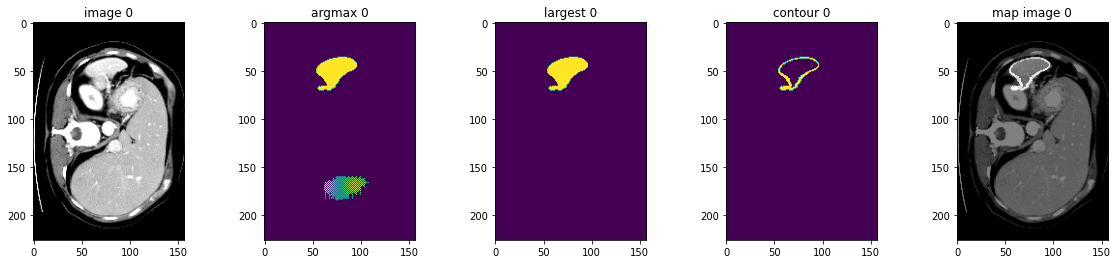

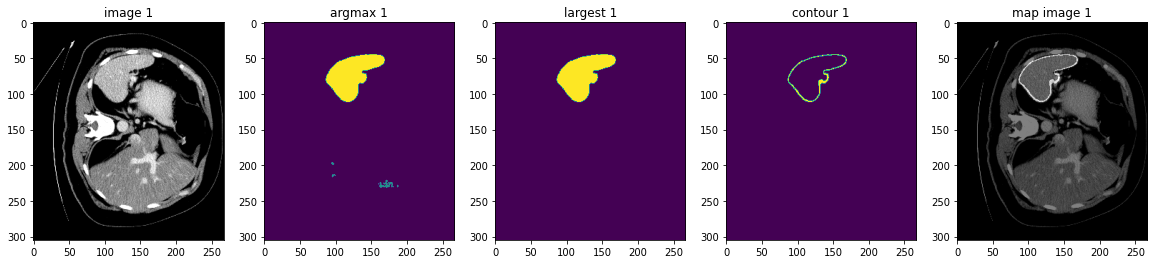

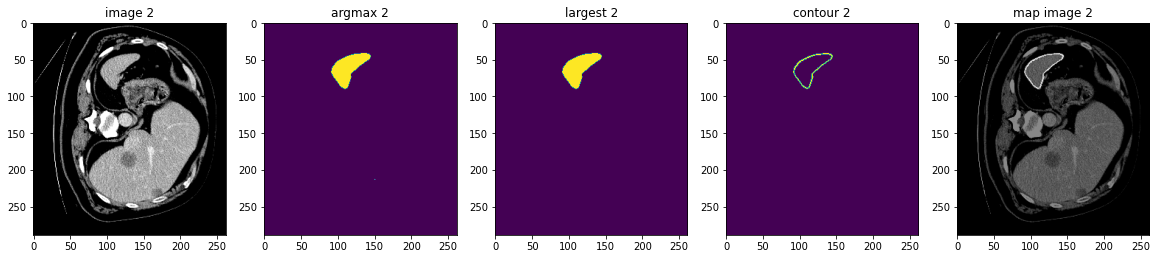

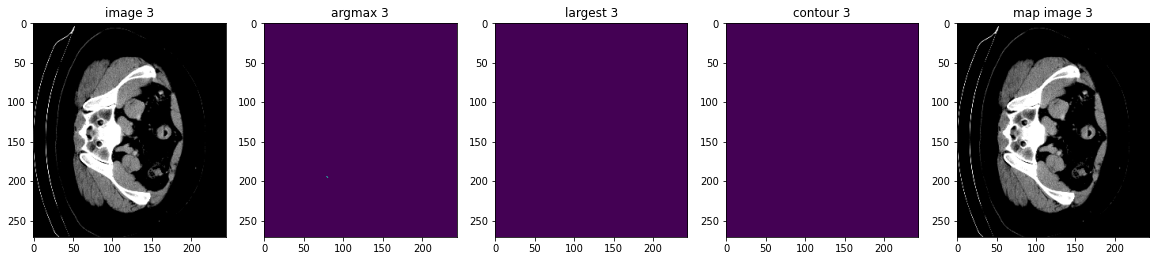

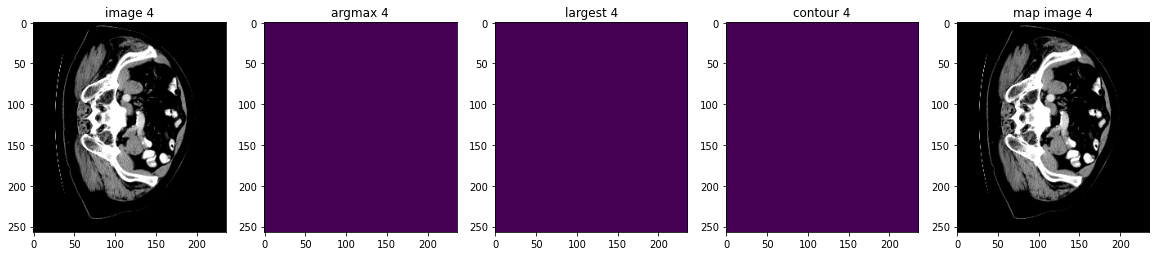

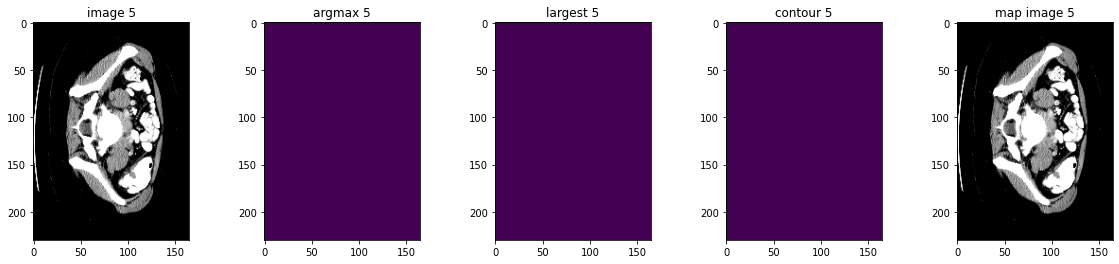

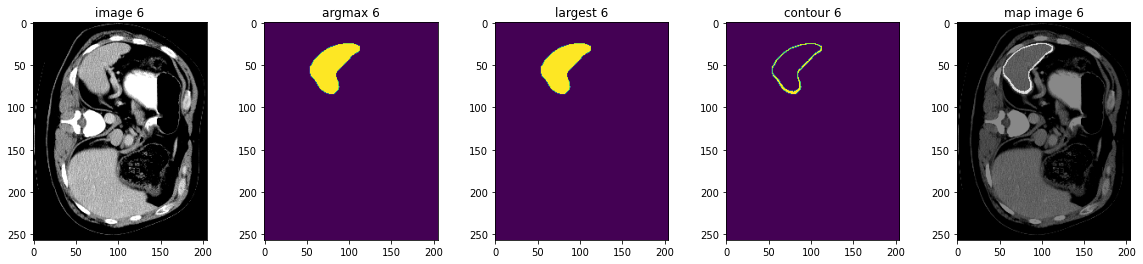

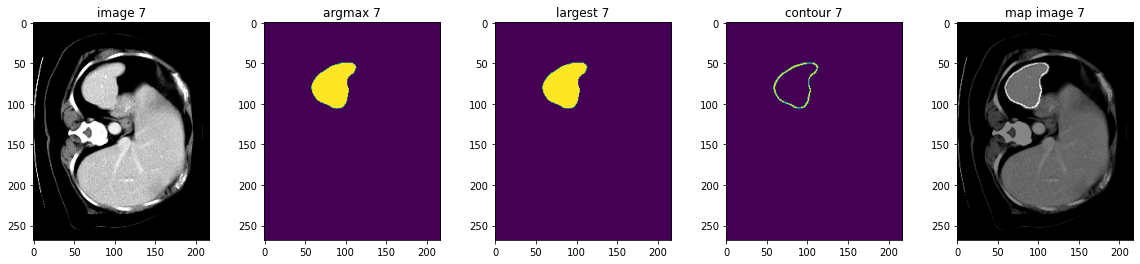

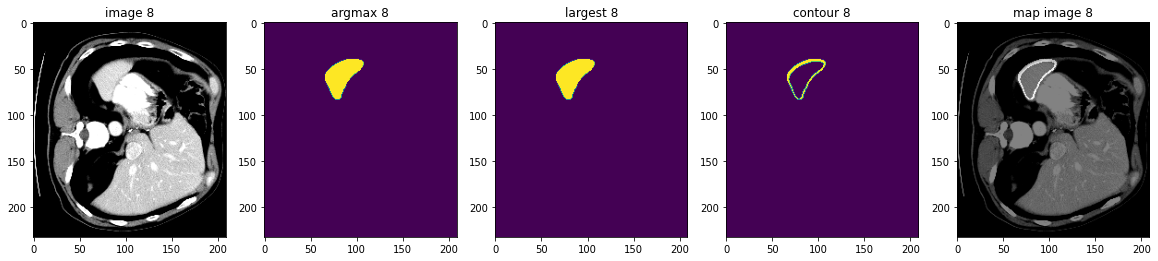

In [12]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data = val_data["image"].to(device)
        val_output = sliding_window_inference(val_data, roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (20, 4))
        plt.subplot(1, 5, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data.detach().cpu()[0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 5, 2)
        plt.title(f"argmax {i}")
        argmax = AsDiscrete(argmax=True)(val_output)
        plt.imshow(argmax.detach().cpu()[0, 0, :, :, 80])
        plt.subplot(1, 5, 3)
        plt.title(f"largest {i}")
        largest = KeepLargestConnectedComponent(applied_labels=[1])(argmax)
        plt.imshow(largest.detach().cpu()[0, 0, :, :, 80])
        plt.subplot(1, 5, 4)
        plt.title(f"contour {i}")
        contour = LabelToContour()(largest)
        plt.imshow(contour.detach().cpu()[0, 0, :, :, 80])
        plt.subplot(1, 5, 5)
        plt.title(f"map image {i}")
        map_image = contour + val_data
        plt.imshow(map_image.detach().cpu()[0, 0, :, :, 80], cmap="gray")
        plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [13]:
if directory is None:
    shutil.rmtree(root_dir)